# Spin Boson Model Examples

### Mean Field calculations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qc_lab import Simulation # import simulation class 
from qc_lab.models import SpinBoson # import model class 
from qc_lab.algorithms import MeanField # import algorithm class 
from qc_lab.dynamics import serial_driver # import dynamics driver


100%|██████████| 3001/3001 [00:01<00:00, 2685.38it/s]


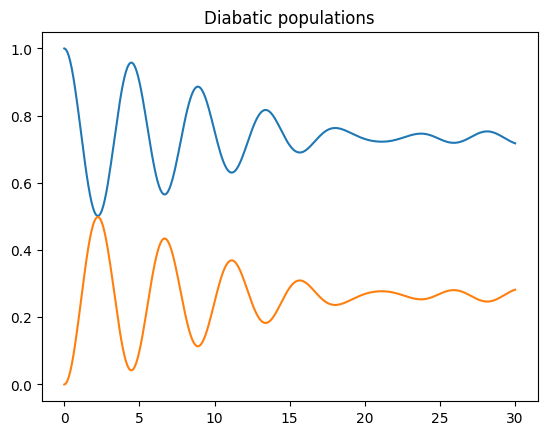

In [2]:

sim = Simulation()

sim.settings.num_trajs = 200
sim.settings.batch_size = 50
sim.settings.tmax = 30
sim.settings.dt = 0.01

sim.model = SpinBoson({
    'V':0.5,
    'E':0.5,
    'A':100,
    'W':0.1,
    'l_reorg':0.005,
    'boson_mass':1.0,
    'temp':1.0,

})
sim.algorithm = MeanField()

sim.state.wf_db= np.zeros((sim.model.constants.num_quantum_states), dtype=complex)
sim.state.wf_db[0] += 1.0

data = serial_driver(sim)

normalize = (sim.settings.num_trajs)
plt.plot(sim.settings.tdat_output, np.real(np.einsum('tii->ti',data.data_dic['dm_db']))/normalize)
plt.title('Diabatic populations')
plt.show()

### Surface Hopping Calculations

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from qc_lab import Simulation # import simulation class 
from qc_lab.models import SpinBoson # import model class 
from qc_lab.algorithms import FewestSwitchesSurfaceHopping # import algorithm class 
from qc_lab.dynamics import serial_driver # import dynamics driver

#### Stochastic sampling

100%|██████████| 3001/3001 [00:02<00:00, 1396.56it/s]


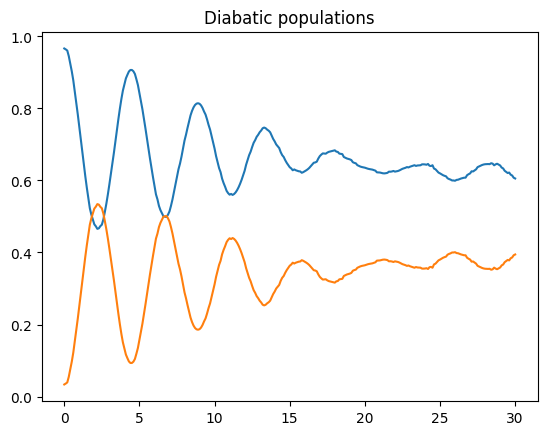

In [4]:
sim = Simulation()

sim.settings.num_trajs = 200
sim.settings.batch_size = 50
sim.settings.tmax = 30
sim.settings.dt = 0.01

sim.model = SpinBoson({
    'V':0.5,
    'E':0.5,
    'A':100,
    'W':0.1,
    'l_reorg':0.005,
    'boson_mass':1.0,
    'temp':1.0,

})
sim.algorithm = FewestSwitchesSurfaceHopping({
    'fssh_deterministic':False,
    'gauge_fixing':0
})

sim.state.wf_db= np.zeros((sim.model.constants.num_quantum_states), dtype=complex)
sim.state.wf_db[0] += 1.0

data = serial_driver(sim)

normalize = (sim.settings.num_trajs)
plt.plot(sim.settings.tdat_output, np.real(np.einsum('tii->ti',data.data_dic['dm_db']))/normalize)
plt.title('Diabatic populations')
plt.show()

#### Deterministic sampling

To use deterministic sampling we multiply the number of trajectories and batch size by the number of states. Note that the convergence behavior changes.

100%|██████████| 3001/3001 [00:14<00:00, 200.70it/s]


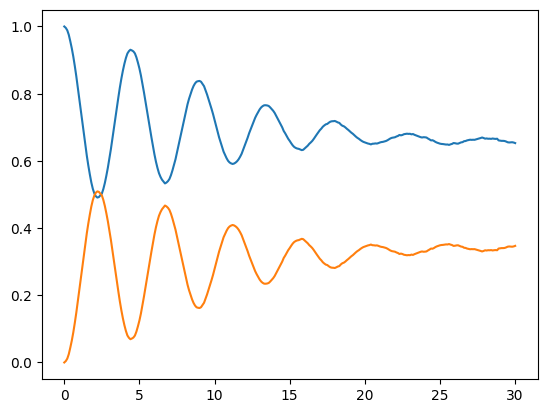

In [ ]:
sim = Simulation()

sim.settings.num_trajs = 200*2
sim.settings.batch_size = 50*2
sim.settings.tmax = 30
sim.settings.dt = 0.01

sim.model = SpinBoson({
    'V':0.5,
    'E':0.5,
    'A':100,
    'W':0.1,
    'l_reorg':0.005,
    'boson_mass':1.0,
    'temp':1.0,

})
sim.algorithm = FewestSwitchesSurfaceHopping({
    'fssh_deterministic':True,
    'gauge_fixing':0
})

sim.state.wf_db= np.zeros((sim.model.constants.num_quantum_states), dtype=complex)
sim.state.wf_db[0] += 1.0

data = serial_driver(sim)

# for deterministic surface hopping the normalization is different
normalize = (sim.settings.num_trajs/sim.model.constants.num_quantum_states)
plt.plot(sim.settings.tdat_output, np.real(np.einsum('tii->ti',data.data_dic['dm_db']))/normalize)
plt.show()

### Using a parllel driver

We will parallelize the above deterministic surface hopping calculation over four tasks.

running  2000 trajectories in batches of 500 on 4 tasks.


100%|██████████| 3001/3001 [00:27<00:00, 110.25it/s]


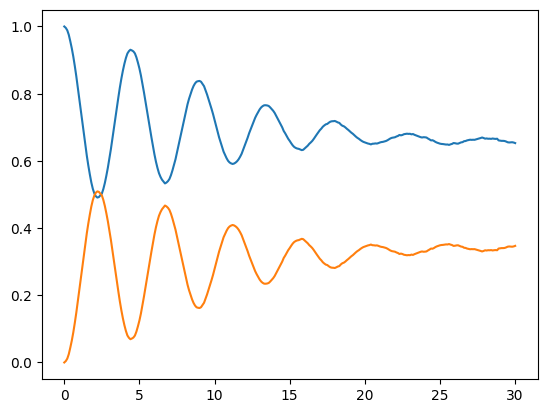

In [ ]:
from qc_lab.dynamics import parallel_driver_multiprocessing # import dynamics driver

sim = Simulation()

sim.settings.num_trajs = 200*2
sim.settings.batch_size = 50*2
sim.settings.tmax = 30
sim.settings.dt = 0.01

sim.model = SpinBoson({
    'V':0.5,
    'E':0.5,
    'A':100,
    'W':0.1,
    'l_reorg':0.005,
    'boson_mass':1.0,
    'temp':1.0,

})
sim.algorithm = FewestSwitchesSurfaceHopping({
    'fssh_deterministic':True,
    'gauge_fixing':0
})

sim.state.wf_db= np.zeros((sim.model.constants.num_quantum_states), dtype=complex)
sim.state.wf_db[0] += 1.0

data = parallel_driver_multiprocessing(sim, num_tasks=4)

# for deterministic surface hopping the normalization is different
normalize = (sim.settings.num_trajs/sim.model.constants.num_quantum_states)
plt.plot(sim.settings.tdat_output, np.real(np.einsum('tii->ti',data.data_dic['dm_db']))/normalize)
plt.show()